## Downscaling Experiment (4 years)

### Boring Stuff

##### Imports

In [1]:
from IPython.display import display
import tensorflow as tf
import os
import numpy as np
import xarray as xr

from visualization.climate_data_visualizer import ClimateDataVisualizer
from visualization.evaluation_visualizer import EvaluationVisualization
from downscaling.pipeline import DownscalingPipeline
from utility.utility import save_to_json, store_to_disk, load_via_url, split_data
from model.modelconfig import UNetModelConfiguration
from utility.data_generator import DataGenerator

%reload_ext autoreload
%autoreload 2


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.Session(config=config)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

##### Settings

In [10]:
normalization_type = 'standardized_anomalies'
#normalization_type = 'min_max'

data_path = './data/'
result_path=('./results/')

#stats_file = './preprocessed_data/climatology_stats_MinMax_4y.json'
#file_cerra = 'preprocessed_data/cerra_preprocessed_min_max_4y.nc'
#file_era = 'preprocessed_data/era5_preprocessed_min_max_4y.nc'

era5_lsm_z_file = f'era5_lsm_z'
cerra_lsm_orog_file = f'cerra_lsm_orog'

file_cerra = 'preprocessed_data/cerra_sa_4y.nc'
file_era = 'preprocessed_data/era5_sa_4y.nc'
stats_file = './preprocessed_data/climatology_stats_sa_4y.json'


### Preprocessing

#### Load from Disk

In [3]:
era5_add_ds = xr.open_dataset(data_path+era5_lsm_z_file+".nc")
cerra_add_ds = xr.open_dataset(data_path+cerra_lsm_orog_file+".nc")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


#### Concat Cerra Data
This step is always needed, as the cerra data have been stored to disk as individual files.

In [4]:
idx_era5 =131
start = 84
idx_cerra = idx_era5

# --- CERRA ---
# Create a list of file paths
file_paths = [os.path.join(data_path, f'cerra0{i}.nc') for i in range(start, idx_cerra)]

# Open multiple files using open_mfdataset
cerra_ds = xr.open_mfdataset(file_paths)#, concat_dim='time')

# Get the size in bytes
size_in_bytes = cerra_ds.nbytes
size_in_gb = size_in_bytes / (1024**3)  # 1 GB = 1024^3 bytes

print(f"Size of the xarray dataset: {size_in_gb:.2f} GB")

display(cerra_ds)


# --- ERA5 ---
# Create a list of file paths
file_paths = [os.path.join(data_path, f'era50{i}.nc') for i in range(start, idx_era5)]

# Open multiple files using open_mfdataset
era5_ds = xr.open_mfdataset(file_paths)#, concat_dim='time')

# Get the size in bytes
size_in_bytes = era5_ds.nbytes
size_in_gb = size_in_bytes / (1024**3)  # 1 GB = 1024^3 bytes

print(f"Size of the xarray dataset: {size_in_gb:.2f} GB")

display(era5_ds)



Size of the xarray dataset: 17.10 GB


<xarray.Dataset>
Dimensions:    (longitude: 801, latitude: 501, time: 11440)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.95 -9.9 -9.85 ... 29.9 29.95 30.0
  * latitude   (latitude) float32 60.0 59.95 59.9 59.85 ... 35.1 35.05 35.0
  * time       (time) datetime64[ns] 2017-01-01 ... 2020-11-30T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 501, 801), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-26 08:25:24 GMT by grib_to_netcdf-2.28.0: grib_to_n...

Size of the xarray dataset: 2.65 GB


<xarray.Dataset>
Dimensions:    (longitude: 281, latitude: 221, time: 11440)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 20.5 20.25 20.0
  * time       (time) datetime64[ns] 2017-01-01 ... 2020-11-30T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 221, 281), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-26 07:31:44 GMT by grib_to_netcdf-2.28.0: grib_to_n...

#### Preprocess Data

In [8]:
lon_min = 8.3
lat_min = 43.8
lon_max = 14.5
lat_max = 51.5

crop_area = [lon_min, lat_min, lon_max, lat_max]

stats_file = './config/climatology_stats_sa_4y.json'

pipeline = DownscalingPipeline(normalization_type)

preprocessed_lr_data, preprocessed_hr_data = pipeline.preprocess_data(era5_ds, cerra_ds, era5_add_ds, cerra_add_ds, crop_region=crop_area, stats_filename=stats_file)

In [10]:
display(preprocessed_lr_data)
display(preprocessed_hr_data)

<xarray.Dataset>
Dimensions:    (longitude: 96, latitude: 128, time: 1430)
Coordinates:
  * longitude  (longitude) float32 9.0 9.05 9.1 9.15 ... 13.6 13.65 13.7 13.75
  * latitude   (latitude) float32 44.5 44.55 44.6 44.65 ... 50.75 50.8 50.85
  * time       (time) datetime64[ns] 2017-01-01T12:00:00 ... 2020-11-30T12:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 -1.044 -1.055 ... -1.232
    lsm        (time, latitude, longitude) float32 -0.4848 -0.4258 ... 0.2752
    z          (time, latitude, longitude) float32 -0.2839 -0.224 ... -0.293
Attributes:
    units:      K
    long_name:  2 metre temperature

<xarray.Dataset>
Dimensions:    (time: 1430, latitude: 128, longitude: 96)
Coordinates:
  * longitude  (longitude) float32 9.0 9.05 9.1 9.15 ... 13.6 13.65 13.7 13.75
  * latitude   (latitude) float32 44.5 44.55 44.6 44.65 ... 50.75 50.8 50.85
  * time       (time) datetime64[ns] 2017-01-01T12:00:00 ... 2020-11-30T12:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 -0.9698 -1.086 ... -1.285
Attributes:
    units:      K
    long_name:  2 metre temperature

#### Store preprocessed data
To avoid repeating the preprocessing steps every time to train the model.

In [11]:
era5_preprocessed_file = f'era5_sa_4y'
cerra_preprocessed_file = f'cerra_sa_4y'

store_to_disk(era5_preprocessed_file, preprocessed_lr_data, data_path)
store_to_disk(cerra_preprocessed_file, preprocessed_hr_data, data_path)

Writing to ./data/era5_sa_4y.nc
Writing to ./data/cerra_sa_4y.nc


### Loading Preprocessed Data

In [4]:
preprocessed_lr_data = xr.open_dataset(file_era)
preprocessed_hr_data = xr.open_dataset(file_cerra)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [6]:
display(preprocessed_hr_data)
display(preprocessed_lr_data)

<xarray.Dataset>
Dimensions:    (time: 1430, latitude: 128, longitude: 96)
Coordinates:
  * longitude  (longitude) float32 9.0 9.05 9.1 9.15 ... 13.6 13.65 13.7 13.75
  * latitude   (latitude) float32 44.5 44.55 44.6 44.65 ... 50.75 50.8 50.85
  * time       (time) datetime64[ns] 2017-01-01T12:00:00 ... 2020-11-30T12:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    units:      K
    long_name:  2 metre temperature

<xarray.Dataset>
Dimensions:    (longitude: 96, latitude: 128, time: 1430)
Coordinates:
  * longitude  (longitude) float32 9.0 9.05 9.1 9.15 ... 13.6 13.65 13.7 13.75
  * latitude   (latitude) float32 44.5 44.55 44.6 44.65 ... 50.75 50.8 50.85
  * time       (time) datetime64[ns] 2017-01-01T12:00:00 ... 2020-11-30T12:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
Attributes:
    units:      K
    long_name:  2 metre temperature

### Data Splitting

In [7]:
lr_train_data, lr_val_data, lr_test_data, hr_train_data, hr_val_data, hr_test_data = split_data(preprocessed_lr_data, preprocessed_hr_data)

train_data = [lr_train_data, hr_train_data]
val_data = [lr_val_data, hr_val_data]
test_data = [lr_test_data, hr_test_data]

In [ ]:
# Calculate ratios
total_lr_data = len(preprocessed_lr_data.time)
total_hr_data = len(preprocessed_lr_data.time)

ratio_lr_train = len(lr_train_data.time) / total_lr_data
ratio_lr_val = len(lr_val_data.time) / total_lr_data
ratio_lr_test = len(lr_test_data.time) / total_lr_data

ratio_hr_train = len(hr_train_data.time) / total_hr_data
ratio_hr_val = len(hr_val_data.time) / total_hr_data
ratio_hr_test = len(hr_test_data.time) / total_hr_data

# Print ratios
print(f"Low-Resolution Data Ratios:")
print(f"Train: {ratio_lr_train:.2%}, Validation: {ratio_lr_val:.2%}, Test: {ratio_lr_test:.2%}")

print("\nHigh-Resolution Data Ratios:")
print(f"Train: {ratio_hr_train:.2%}, Validation: {ratio_hr_val:.2%}, Test: {ratio_hr_test:.2%}")

display(lr_train_data)
display(lr_val_data)
display(lr_test_data)

In [13]:
data_path = './data_split/'

store_to_disk('lr_train_sa_4y', lr_train_data, data_path)
store_to_disk('hr_train_sa_4y', hr_train_data, data_path)

store_to_disk('lr_val_sa_4y', lr_val_data, data_path)
store_to_disk('hr_val_sa_4y', hr_val_data, data_path)

store_to_disk('lr_test_sa_4y', lr_test_data, data_path)
store_to_disk('hr_test_sa_4y', hr_test_data, data_path)

Writing to ./data_split/lr_train_sa_4y.nc
Writing to ./data_split/hr_train_sa_4y.nc
Writing to ./data_split/lr_val_sa_4y.nc
Writing to ./data_split/hr_val_sa_4y.nc
Writing to ./data_split/lr_test_sa_4y.nc
Writing to ./data_split/hr_test_sa_4y.nc


### Utility Functionality for Running the Model 

In [14]:
def run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix):
    pipeline = DownscalingPipeline(normalization_type)

    train_data_generator = DataGenerator(train_data[0], train_data[1], model_setup['batch_size'])
    val_data_generator = DataGenerator(val_data[0], val_data[1], model_setup['batch_size'])

    model = pipeline.fit_model(
        train_generator = train_data_generator,
        val_generator = val_data_generator,
        scheduler_type = model_setup['scheduler_type'],
        learning_rate_value = model_setup['learning_rate_value'],
        num_epochs = model_setup['num_epochs'],
        loss_type = model_setup['loss_type'],
        filters = model_setup['filters']
        #show_summary = True
    )

    pipeline.show_training_history(filename_suffix)

    # Predict unseen data
    result = pipeline.predict(lr_test_data, stats_file)

    # evaluate predicted data
    hr_test_denormalized = pipeline.denormalize(data=hr_test_data, stats_filename=stats_file, resolution='hr')
    metric_results = pipeline.evaluate_prediction(hr_test_denormalized, result)

    visualizer = EvaluationVisualization()
    visualizer.spatial_plots(hr_test_denormalized, result, filename_suffix)
    visualizer.difference_maps(hr_test_denormalized, result, filename_suffix)
    visualizer.histograms(hr_test_denormalized, result, filename_suffix)

    history = pipeline.get_history()
    save_to_json(filename_suffix, model_setup, history['loss'], history['val_loss'], metric_results, result_path)    

### Hyperparameter Optimization

#### Parameter Setting

In [11]:
filename_suffix = ''
last_idx=500

normalization_types = ['standardized_anomalies', 'min_max']
scheduler_types = ['step_decay', 'exponential_decay', 'time_decay'] 
learning_rate_values = [1e-1, 1e-2, 1e-3, 1e-4]
loss_types = ['mse', 'mae', 'huber_loss'] 
num_epochs_list = [2, 4, 10, 15, 20, 30, 50]
batch_sizes = [8, 16, 32, 64]
initial_filters = [16, 32, 56, 64]

model_configuration = UNetModelConfiguration()

### Hyperparameter Optimization for Standardized Anomalies

In [ ]:
# try more filters 
# try more batches

141/141 [==============================] - 305s 2s/step - loss: 0.4051 - val_loss: 0.1908 - lr: 0.0100


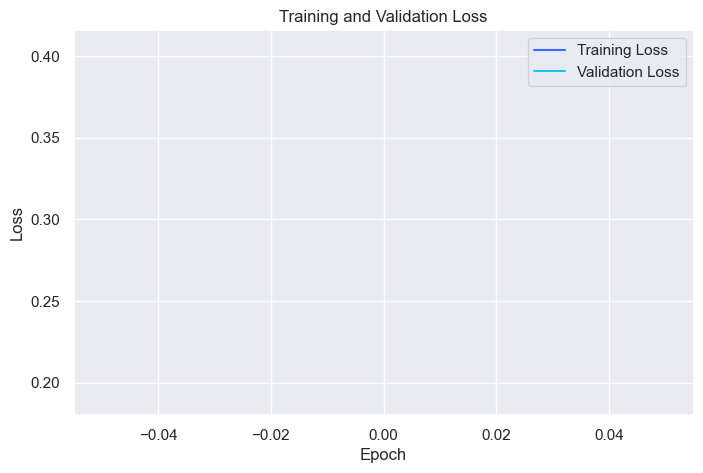

5/5 [==============================] - 12s 2s/step
--- true: ---
min 253.8877
max 312.46213
range true: 58.574432
rmse % true:  8.744613826274872
--- pred: ---
min 266.8878
max 302.27966
range pred 35.391876
rmse % pred:  14.472553133964539
---------
mae % true:  7.210723310709
mae % pred:  11.933926492929459

Metrics:
╒═════════╤═════════╤═════════════╤═════════╕
│    RMSE │     MAE │   Max Error │    Bias │
╞═════════╪═════════╪═════════════╪═════════╡
│ 5.12211 │ 4.22364 │     23.6317 │ 1.15728 │
╘═════════╧═════════╧═════════════╧═════════╛


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


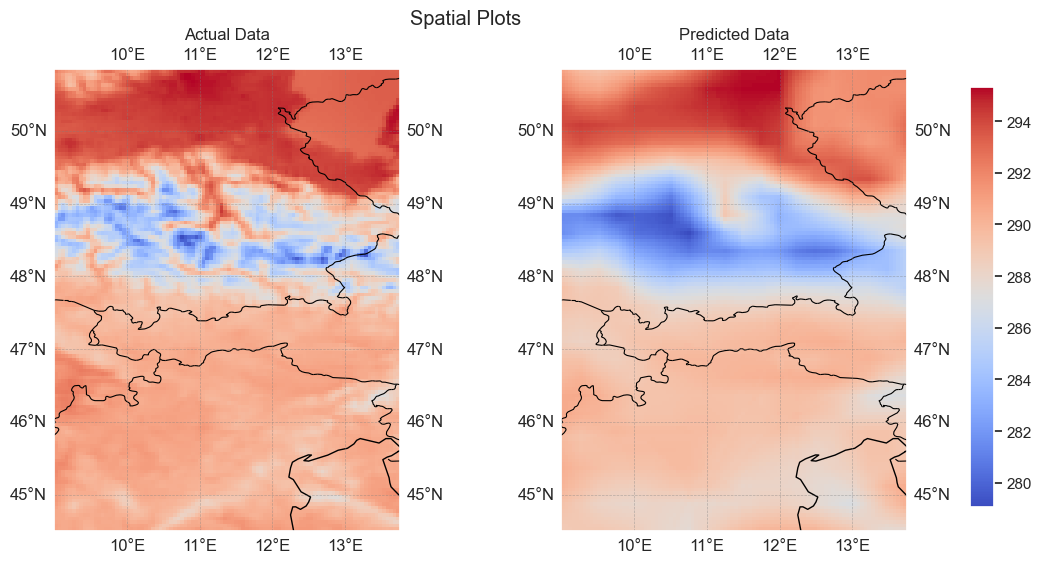

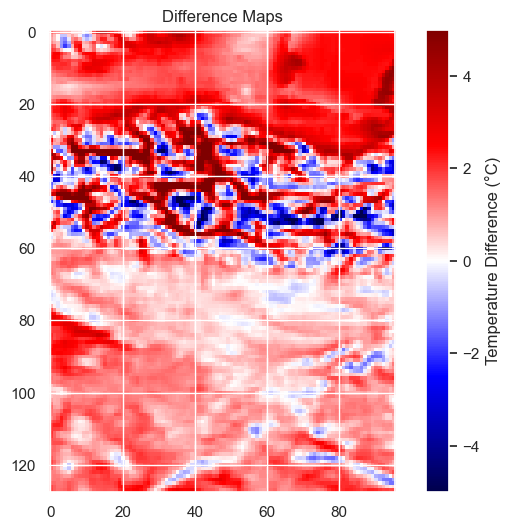

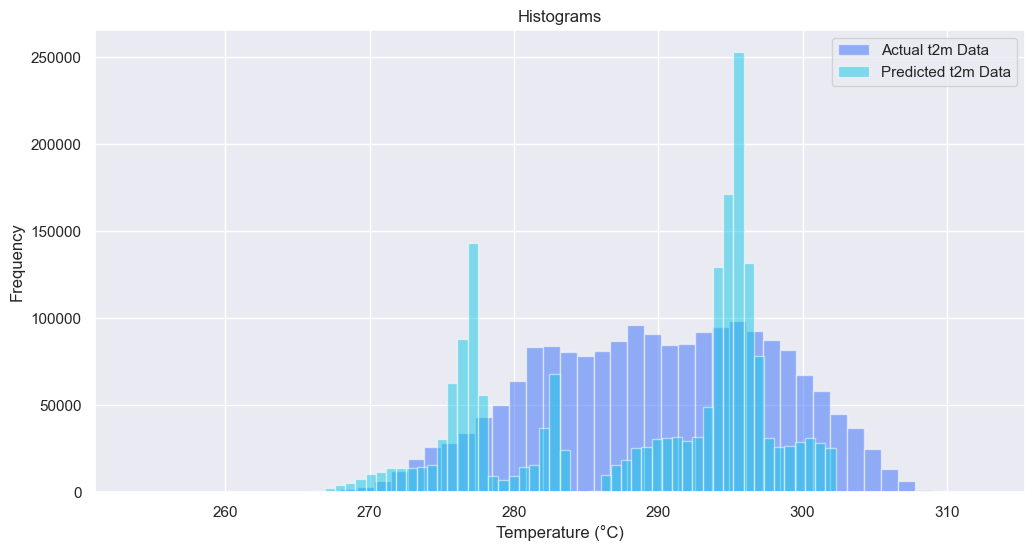

In [23]:
normalization_type = normalization_types[0]
scheduler_type = scheduler_types[2]
learning_rate_value = learning_rate_values[1]
num_epochs = 10
batch_size = batch_sizes[0]
loss_type = loss_types[2]
initial_filter = initial_filters[2]
filters = model_configuration.generate_filters(initial_filter)
last_idx=0

model_setup = {
    'scheduler_type': scheduler_type,
    'learning_rate_value': learning_rate_value,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'loss_type': loss_type,
    'filters': filters,
    'activation_function': 'tanh',
    'note': '4y, cropped area'
}

filename_suffix = '_test_4y_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1

#### Try different scheduler types
Need +10 epochs so it works out 

In [ ]:
# base settings
normalization_type = normalization_types[0]
scheduler_type = scheduler_types[0]
learning_rate_value = learning_rate_values[2]
num_epochs = num_epochs_list[3]
batch_size = batch_sizes[2]
loss_type = loss_types[2] 
initial_filter = initial_filters[1]
filters = model_configuration.generate_filters(initial_filter)
last_idx=0

model_setup = {
    'scheduler_type': scheduler_type,
    'learning_rate_value': learning_rate_value,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'loss_type': loss_type,
    'filters': filters,
    'activation_function': 'tanh', 
    'note': '4y, cropped area'
}


# ------------ step_decay ------------
model_setup['scheduler_type'] = scheduler_types[0]

filename_suffix = 'sa_scheduler_type_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ exponential_decay ------------
model_setup['scheduler_type'] = scheduler_types[1]

filename_suffix = 'sa_scheduler_type_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ time_decay ------------
model_setup['scheduler_type'] = scheduler_types[2]
filename_suffix = 'sa_scheduler_type_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1

#### Testing different loss types

In [ ]:
# base settings
normalization_type = normalization_types[0]
scheduler_type = scheduler_types[1]
learning_rate_value = learning_rate_values[2]
num_epochs = num_epochs_list[3]
batch_size = batch_sizes[2]
loss_type = loss_types[0] 
initial_filter = initial_filters[1]
filters = model_configuration.generate_filters(initial_filter)
last_idx=0

model_setup = {
    'scheduler_type': scheduler_type,
    'learning_rate_value': learning_rate_value,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'loss_type': loss_type,
    'filters': filters,
    'activation_function': 'tanh', 
    'note': '4y, cropped area'
}


# ------------ mse ------------
model_setup['loss_type']=loss_types[0] 

filename_suffix = 'sa_loss_type_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ mae ------------
model_setup['loss_type']=loss_types[1] 


filename_suffix = 'sa_loss_type_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ huber_loss ------------
model_setup['loss_type']=loss_types[2] 

filename_suffix = 'sa_loss_type_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)

#### Testing different batch sizes

In [ ]:
# base settings
normalization_type = normalization_types[0]
scheduler_type = scheduler_types[1]
learning_rate_value = learning_rate_values[2]
num_epochs = num_epochs_list[3]
batch_size = batch_sizes[2]
loss_type = loss_types[0] 
initial_filter = initial_filters[1]
filters = model_configuration.generate_filters(initial_filter)
last_idx=0

model_setup = {
    'scheduler_type': scheduler_type,
    'learning_rate_value': learning_rate_value,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'loss_type': loss_type,
    'filters': filters,
    'activation_function': 'tanh', 
    'note': '4y, cropped area'
}


# ------------ 8 ------------
model_setup['batch_size']=batch_sizes[0] 

filename_suffix = 'sa_batch_size_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ 16 ------------
model_setup['batch_size']=batch_sizes[1] 


filename_suffix = 'sa_batch_size_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ 32 ------------
model_setup['batch_size']=batch_sizes[2] 

filename_suffix = 'sa_batch_size_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1


# ------------ 64 ------------
model_setup['batch_size']=batch_sizes[3] 

filename_suffix = 'sa_batch_size_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)

#### Testing different learning rates

In [ ]:
# base settings
normalization_type = normalization_types[0]
scheduler_type = scheduler_types[1]
learning_rate_value = learning_rate_values[2]
num_epochs = num_epochs_list[3]
batch_size = batch_sizes[2]
loss_type = loss_types[0] 
initial_filter = initial_filters[1]
filters = model_configuration.generate_filters(initial_filter)
last_idx=0

model_setup = {
    'scheduler_type': scheduler_type,
    'learning_rate_value': learning_rate_value,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'loss_type': loss_type,
    'filters': filters,
    'activation_function': 'tanh', 
    'note': '4y, cropped area'
}


# ------------ 1e-4 ------------
model_setup['learning_rate_value']=learning_rate_values[0] 

filename_suffix = 'sa_learn_rate_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------  1e-4 ------------
model_setup['learning_rate_value']=learning_rate_values[1] 

filename_suffix = 'sa_learn_rate_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ 1e-4 ------------
model_setup['learning_rate_value']=learning_rate_values[2] 

filename_suffix = 'sa_learn_rate_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1


# ------------ 1e-4 ------------
model_setup['learning_rate_value']=learning_rate_values[3] 

filename_suffix = 'sa_learn_rate_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)

#### Testing different filters

In [ ]:
# base settings
normalization_type = normalization_types[0]
scheduler_type = scheduler_types[1]
learning_rate_value = learning_rate_values[2]
num_epochs = num_epochs_list[3]
batch_size = batch_sizes[2]
loss_type = loss_types[0] 
initial_filter = initial_filters[1]
filters = model_configuration.generate_filters(initial_filter)
last_idx=0

model_setup = {
    'scheduler_type': scheduler_type,
    'learning_rate_value': learning_rate_value,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'loss_type': loss_type,
    'filters': filters,
    'activation_function': 'tanh', 
    'note': '4y, cropped area'
}


# ------------ 16 ------------
model_setup['filters']=filters[0] 

filename_suffix = 'sa_filters_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------  32 ------------
model_setup['filters']=filters[1] 

filename_suffix = 'sa_filters_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ 56 ------------
model_setup['filters']=filters[2] 

filename_suffix = 'sa_filters_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1


# ------------ 64 ------------
model_setup['filters']=filters[3] 

filename_suffix = 'sa_filters_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)

### Hyperparametr Optimization for Min Max

fewer tests ?